In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import numba

simulation:

In [61]:
@numba.jit
def relax(r,theta,potential, R, alpha):
    n = potential.shape[0] - 1
    for i in range(1,n):
        for j in range(1,n):
            rr = r[i][j]
            tt = theta[i][j]
            if rr <= R:
                if np.rad2deg(tt)<=np.rad2deg(alpha):
                    if np.rad2deg(tt)>=0:
                        continue
            potential[i][j] = 1/4 * (potential[i+1][j] + potential[i-1][j] + 
                                    potential[i][j+1] + potential[i][j-1])
    return potential

class simulation:

    def __init__(self, R, dn, lower_bound, upper_bound, alpha, U_boundary):
        self.R = R
        self.dn = dn
        self.alpha = alpha
        self.U_boundary = U_boundary
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.X, self.Y = self.create_mesh()
        self.r = np.hypot(self.X,self.Y)
        self.theta = np.select([self.Y>0, self.Y<0] ,
                               [np.arctan2(self.Y,self.X), np.arctan2(self.Y,self.X)+2*np.pi])
        self.potential_init = self.init_potential()
        self.potential_solved = np.copy(self.potential_init)
    
    def create_mesh(self):
        x = np.arange(self.lower_bound, self.upper_bound, self.dn)
        y = np.arange(self.lower_bound, self.upper_bound, self.dn)
        return np.meshgrid(x,y)
    
    def init_potential(self):
        potential = np.zeros(self.X.shape)
        boundary = np.logical_and(np.logical_and(np.rad2deg(self.theta)<=np.rad2deg(self.alpha), np.rad2deg(self.theta)>=0), 
                            np.logical_and(self.R-self.r>0, self.R-self.r<=self.dn))
        potential = np.select([boundary], [self.U_boundary(self.theta, self.alpha)])
        return potential
    
    # # @numba.jit
    # def relax(self):
    #     n = self.potential.shape[0] - 1
    #     for i in range(n):
    #         for j in range(n):
    #             rr = self.r[i][j]
    #             tt = self.theta[i][j]
    #             if rr <= self.R:
    #                 if np.all([(np.rad2deg(tt)<=np.rad2deg(self.alpha)),(np.rad2deg(tt)>=0)]):
    #                     continue
    #             if np.any([(self.upper_bound - np.abs(self.X[i]) <= self.dn),
    #                        (self.upper_bound - np.abs(self.Y[j]) <= self.dn)]):
    #                 continue
    #             self.potential_solved[i][j] = 1/4 * (self.potential_solved[i+1][j] + self.potential_solved[i-1][j] + 
    #                                                     self.potential_solved[i][j+1] + self.potential_solved[i][j-1])

    def solve_potential(self, max_iter):
        for k in tqdm(range(max_iter)):
            time.sleep(0.1)
            self.solve_potential = relax(self.r, self.theta, 
                                         self.potential_solved, self.R, self.alpha)
        


set parameters

In [51]:
R = 1
alpha_arr = [np.pi/3, np.pi, np.pi * (3/2)]
dn_arr = [0.04 ,0.02, 0.01]
U_boundary_arr = [lambda a,b: a*(b-a), lambda a,b: np.sin(5*a*(b-a)), lambda a,b: np.sin(5*a*(b-a))**2]
upper_bound = 4
lower_bound = -4
max_iter = 10000

# resolution comparison

In [64]:
alpha = alpha_arr[-1]  # test for widest angle for boundary effects
U_boundary = U_boundary_arr[-1]

potentials_res_comp = []
for dn in dn_arr:
    potentials_res_comp.append(simulation(R, dn, lower_bound, upper_bound, alpha, U_boundary))
    potentials_res_comp[-1].solve_potential(max_iter)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [18:44<00:00,  8.89it/s]


(200, 200)
(400, 400)
(800, 800)


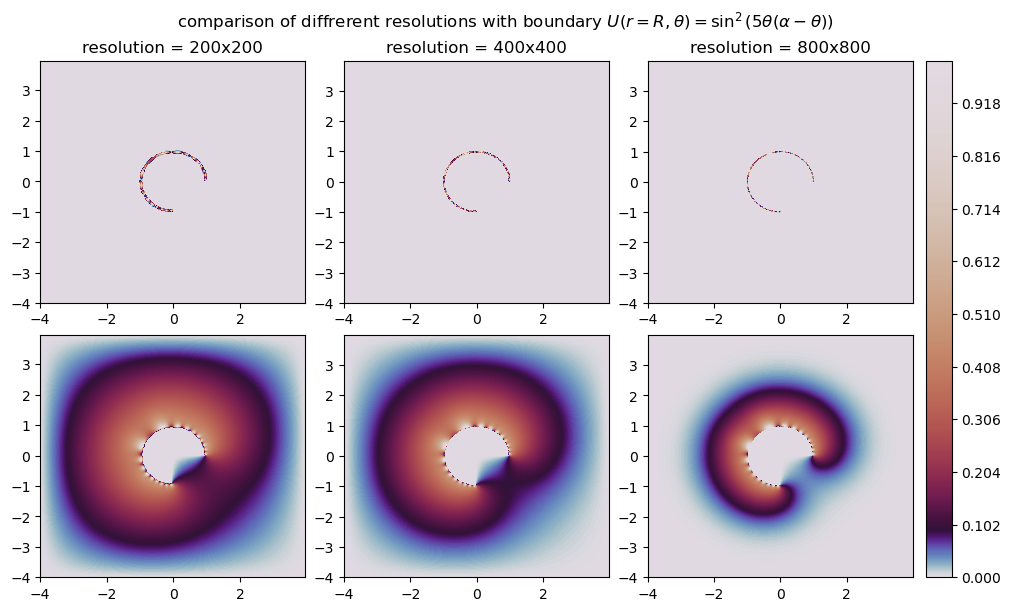

In [67]:
fig, ax = plt.subplots(2, 3, figsize=(10,6), layout='constrained')
fig.suptitle(r'comparison of diffrerent resolutions with boundary $U(r=R,\theta)=\sin^2{(5\theta (\alpha-\theta))}$')
res_text = ['200x200', '400x400', '800x800']
for i in range(3):
    print(potentials_res_comp[i].potential_init.shape)
    ax[0][i].contourf(potentials_res_comp[i].X, potentials_res_comp[i].Y, potentials_res_comp[i].potential_init, 
                   500, cmap='twilight' ,norm=mpl.colors.SymLogNorm(0.1))
    ax[0][i].set_title(f'resolution = {res_text[i]}')
    pcm = ax[1][i].contourf(potentials_res_comp[i].X, potentials_res_comp[i].Y, potentials_res_comp[i].potential_solved, 
                   500, cmap='twilight' ,norm=mpl.colors.SymLogNorm(0.1))
 
fig.colorbar(pcm, ax=ax[:, 2])

# angle comparison

In [54]:
U_boundary = U_boundary_arr[-1]
dn = dn_arr[-1]

potentials_angle_comp = []
for alpha in alpha_arr:
    potentials_angle_comp.append(simulation(R, dn, lower_bound, upper_bound, alpha, U_boundary))
    potentials_angle_comp[-1].solve_potential(max_iter)

100%|██████████| 10000/10000 [18:11<00:00,  9.16it/s]


AttributeError: 'simulation' object has no attribute 'potential_init'

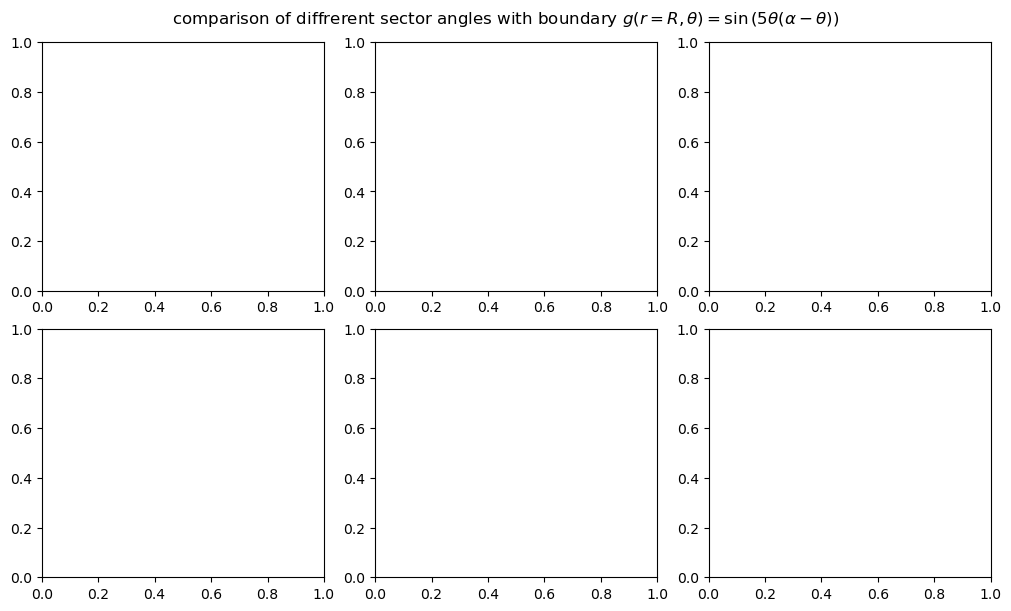

In [60]:
fig, ax = plt.subplots(2, 3, figsize=(10,6), layout='constrained')
fig.suptitle(r'comparison of diffrerent sector angles with boundary $g(r=R,\theta)=\sin{(5\theta (\alpha-\theta))}$')

for i in range(3):
    pot = potentials_angle_comp[i]
    ax[0][i].contourf(potentials_angle_comp[i].X, potentials_angle_comp[i].Y, potentials_angle_comp[i].potential_init, 
                   500, cmap='twilight' ,norm=mpl.colors.SymLogNorm(0.1))
    ax[0][i].set_title(f'angle = {np.rad2deg(alpha_arr[i]):.1f}')
    pcm = ax[1][i].contourf(potentials_angle_comp[i].X, potentials_angle_comp[i].Y, potentials_angle_comp[i].potential_solved, 
                            500, cmap='twilight' ,norm=mpl.colors.SymLogNorm(0.1))
    
fig.colorbar(pcm, ax=ax[:, 2])


# function comparison

In [56]:
alpha = alpha_arr[-1]
dn = dn_arr[-1]

potentials_boundary_comp = []
for U_boundary in U_boundary_arr:
    potentials_boundary_comp.append(simulation(R, dn, lower_bound, upper_bound, alpha, U_boundary))
    potentials_boundary_comp[-1].solve_potential(max_iter)

100%|██████████| 10000/10000 [18:11<00:00,  9.16it/s]


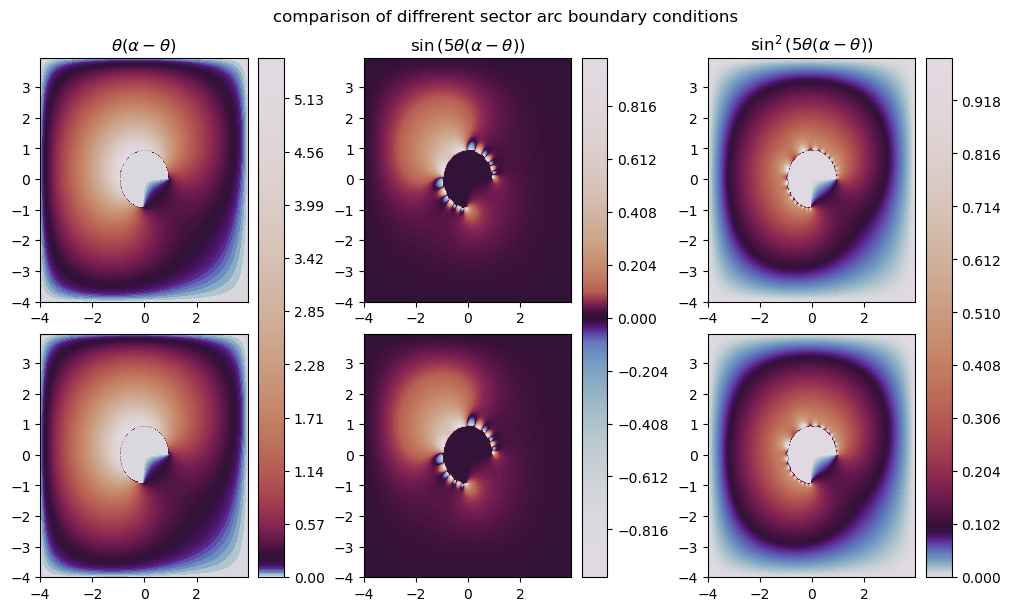

In [57]:
boundary_text = [r'$\theta (\alpha - \theta)$', r'$\sin{(5\theta (\alpha - \theta))}$', r'$\sin^2{(5\theta (\alpha - \theta))}$']

fig, ax = plt.subplots(2, 3, figsize=(10,6), layout='constrained')
fig.suptitle(r'comparison of diffrerent sector arc boundary conditions')

for i in range(3):
    pot = potentials_boundary_comp[i]
    ax[0][i].contourf(potentials_boundary_comp[i].X, potentials_boundary_comp[i].Y, potentials_boundary_comp[i].potential, 
                      500, cmap='twilight' ,norm=mpl.colors.SymLogNorm(0.1))
    ax[0][i].set_title(boundary_text[i])
    pcm = ax[1][i].contourf(potentials_boundary_comp[i].X, potentials_boundary_comp[i].Y, potentials_boundary_comp[i].potential_solved, 
                            500, cmap='twilight' ,norm=mpl.colors.SymLogNorm(0.1))
    fig.colorbar(pcm, ax=ax[:, i])

to delete

In [7]:
x = np.arange(lower_bound, upper_bound, dn)
y = np.arange(lower_bound, upper_bound, dn)
X, Y = np.meshgrid(x,y)
r = np.hypot(X,Y)
# theta = np.arctan2(Y,X)
theta = np.select([Y>0, Y<0] ,[np.arctan2(Y,X), np.arctan2(Y,X)+2*np.pi])
potential = np.zeros(X.shape)
print(potential.shape)
boundary = np.logical_and(np.logical_and(np.rad2deg(theta)<=np.rad2deg(alpha), np.rad2deg(theta)>=0), 
                            np.logical_and(R-r>0, R-r<=dn))
potential = np.select([boundary], [np.sin(5*theta*(alpha-theta))])

TypeError: unsupported operand type(s) for /: 'int' and 'list'

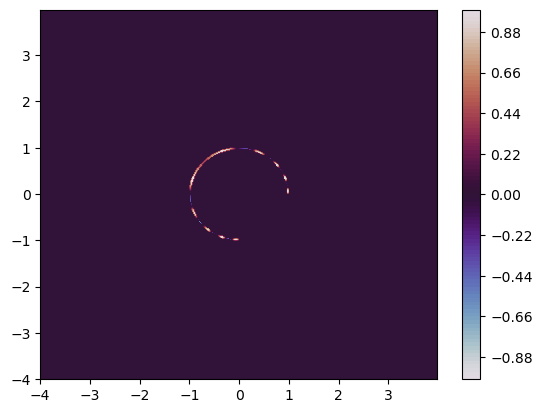

In [ ]:
fig = plt.figure()
plt.contourf(X, Y, potential, 100, cmap='twilight')
plt.colorbar()


In [ ]:
@numba.jit
def solve(xx, yy, potential):
    mean_before = potential.mean()
    for i in range(n-1):
        for j in range(n-1):
            rr = r[i][j]
            tt = theta[i][j]
            condition = ((rr<=R) and 
                         (np.rad2deg(tt)<=np.rad2deg(alpha)) and 
                         (np.rad2deg(tt)>=0)) or (upper_bound - np.abs(xx[i]) <= dn) or (upper_bound - np.abs(yy[j]) <= dn)
            if not condition:
                potential[i][j] = 1/4 * (potential[i+1][j] + potential[i-1][j] + potential[i][j+1] + potential[i][j-1])
    return potential, potential.mean()-mean_before

In [ ]:
max_iter = 10000
err_arr = []

for k in tqdm(range(max_iter)):
    time.sleep(0.1)
    potential_solved, err = solve(x, y, potential)
    err_arr.append(err)

100%|██████████| 10000/10000 [18:14<00:00,  9.13it/s]


Text(0.5, 1.0, 'error as a function of iterations')

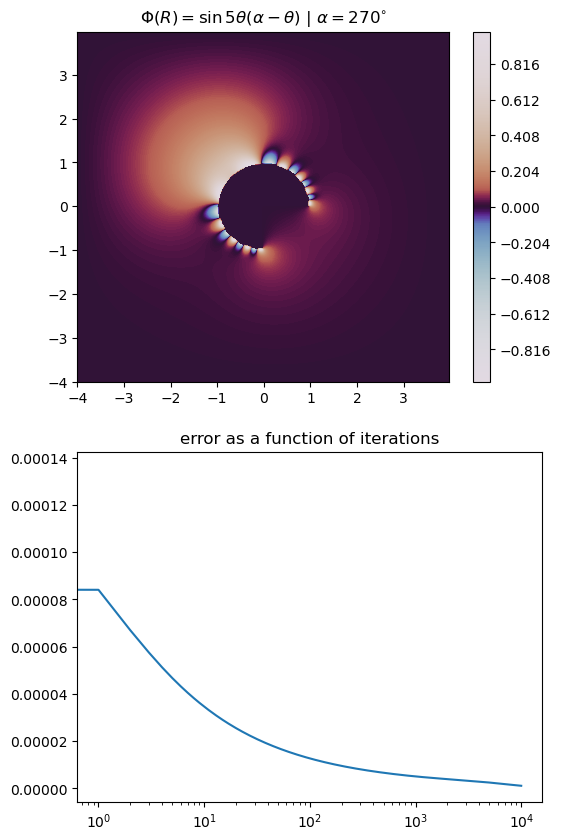

In [ ]:
fig , ax = plt.subplots(2,1, figsize=(6,10))

im = ax[0].contourf(X, Y, potential_solved, 500, cmap='twilight' ,norm=mpl.colors.SymLogNorm(0.1))
plt.colorbar(im)
ax[0].set_title(r'$\Phi (R)=\sin{5\theta (\alpha - \theta)}$ | $\alpha =270^{\circ} $')

ax[1].semilogx(np.arange(0, max_iter, 1), err_arr)
ax[1].set_title('error as a function of iterations')
